# Define EMU mask bounds

In [22]:
# tell Python to use the ecco_v4_py in the 'ECCOv4-py' repository
from os.path import join,expanduser
import sys

# identify user's home directory
user_home_dir = expanduser('~')

# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco

import botocore  
import boto3
import cartopy.crs as ccrs
from boto3.session import Session
import cmocean
from collections import Counter
from dask.distributed import Client
import datetime
import fsspec
from gc import get_referents
import json
import numpy as np
from pathlib import Path
from pprint import pprint
import requests
import s3fs
import sys
from sys import getsizeof
import time as time
from types import ModuleType, FunctionType
import xarray as xr
import matplotlib.pyplot as plt
import zarr


In [3]:
# Use this for the netcdf files stored on an s3 bucket
def get_credentials(use_earthdata=False):
    """
    This routine automatically pulls your EDL crediential from .netrc file and use it to obtain an AWS S3 credential 
    through a PO.DAAC service accessible at https://archive.podaac.earthdata.nasa.gov/s3credentials.
    From the PO.DAAC Github (https://podaac.github.io/tutorials/external/July_2022_Earthdata_Webinar.html).
    
    Returns:
    =======
    
    credentials: a dictionary with AWS secret_key, access_key, and token
    """
    # NASA EarthData hosts ECCO V4r4 fileds
    if use_earthdata == False:
        session = boto3.Session()
        credentials_b3 = session.get_credentials()
        creds_b3 = credentials_b3.get_frozen_credentials()
        
        credentials = dict()
        credentials['secretAccessKey'] = credentials_b3.secret_key
        credentials['accessKeyId'] = credentials_b3.access_key
        credentials['sessionToken'] = credentials_b3.token

    # A 'public' AWS s3 bucket hosts V4r5 fields (they will eventually move to PO.DAAC)
    else:
        credentials = requests.get('https://archive.podaac.earthdata.nasa.gov/s3credentials').json()
    
    return credentials
    

In [4]:
def init_S3FileSystem(use_earthdata=False, requester_pays=True):
    """
    This routine automatically creates an 's3 file system' object and credentials dictionary.
    The s3 file system needs to be initialized with the special aws credentials.
    
    Returns:
    =======
    
    s3: an AWS S3 filesystem, 
    credentials: a dictionary with AWS secret_key, access_key, and token

    """
    credentials = get_credentials(use_earthdata=use_earthdata)

    if use_earthdata:
        requester_pays = False
        
    s3 = s3fs.S3FileSystem(requester_pays=requester_pays,
                           anon=False,
                           key=credentials['accessKeyId'],
                           secret=credentials['secretAccessKey'], 
                           token=credentials['sessionToken'])
    
    return s3, credentials

In [5]:
# function for determining the memory footprint of an object

# ... from https://stackoverflow.com/questions/449560/how-do-i-determine-the-size-of-an-object-in-python

# Custom objects know their class.
# Function objects seem to know way too much, including modules.
# Exclude modules as well.
BLACKLIST = type, ModuleType, FunctionType

def getsize(obj):
    """
    This routine returns the in-memory size of an python object
    
    Returns:
    =======
    
    size: size of object & members.
    """
    if isinstance(obj, BLACKLIST):
        raise TypeError('getsize() does not take argument of type: '+ str(type(obj)))
    seen_ids = set()
    size = 0
    objects = [obj]
    while objects:
        need_referents = []
        for obj in objects:
            if not isinstance(obj, BLACKLIST) and id(obj) not in seen_ids:
                seen_ids.add(id(obj))
                size += sys.getsizeof(obj)
                need_referents.append(obj)
        objects = get_referents(*need_referents)
    return size

In [6]:
s3, credentials = init_S3FileSystem(use_earthdata=False, requester_pays=True);

In [7]:
mzz_local_directory = Path('/efs_ecco/mzz-jsons-V4r5/MZZ_day_mean_latlon')
# different prefixes on s3
# MZZ_day_mean_latlon
# MZZ_day_mean_native
# MZZ_mon_mean_latlon
# MZZ_mon_mean_native
# MZZ_snap_native

In [8]:
# show they are on the local disk 
np.sort(list(mzz_local_directory.glob('*json')))

array([PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_day_mean_latlon/ATM_SURFACE_TEMP_HUM_WIND_PRES_day_mean_latlon_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_day_mean_latlon/ATM_SURFACE_TEMP_HUM_WIND_PRES_mon_mean_latlon_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_day_mean_latlon/OCEAN_AND_ICE_SURFACE_FW_FLUX_day_mean_latlon_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_day_mean_latlon/OCEAN_AND_ICE_SURFACE_FW_FLUX_mon_mean_latlon_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_day_mean_latlon/OCEAN_AND_ICE_SURFACE_HEAT_FLUX_day_mean_latlon_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_day_mean_latlon/OCEAN_AND_ICE_SURFACE_HEAT_FLUX_mon_mean_latlon_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_day_mean_latlon/OCEAN_AND_ICE_SURFACE_STRESS_day_mean_latlon_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_day_mean_latlon/O

In [9]:
# MZZ files have been downloaded. 

# select the temperature/salinity dataset
mzz_local_file= mzz_local_directory / 'OCEAN_TEMPERATURE_SALINITY_mon_mean_latlon_llc090_ECCOV4r5.json'
print(mzz_local_file)

/efs_ecco/mzz-jsons-V4r5/MZZ_day_mean_latlon/OCEAN_TEMPERATURE_SALINITY_mon_mean_latlon_llc090_ECCOV4r5.json


In [10]:
import fsspec
import zarr

In [11]:
fs = fsspec.filesystem("reference",     
                       fo=str(mzz_local_file),
                       remote_protocol="s3",
                       remote_options={"anon":False, "requester_pays":True},
                       skip_instance_cache=True)
# 
fs.asynchronous = True
store = zarr.storage.FsspecStore(fs)
ds = xr.open_dataset(store, engine='zarr',
                     consolidated=False, chunks={'time':4, 'Z':50})

ds

<xarray.Dataset> Size: 35GB
Dimensions:         (time: 336, Z: 50, latitude: 360, longitude: 720, nv: 2)
Coordinates:
  * time            (time) datetime64[ns] 3kB 1992-01-16T18:00:00 ... 2019-12-16
  * Z               (Z) float32 200B -5.0 -15.0 -25.0 ... -5.461e+03 -5.906e+03
    Z_bnds          (Z, nv) float32 400B dask.array<chunksize=(50, 2), meta=np.ndarray>
  * latitude        (latitude) float32 1kB -89.75 -89.25 -88.75 ... 89.25 89.75
    latitude_bnds   (latitude, nv) float32 3kB dask.array<chunksize=(360, 2), meta=np.ndarray>
  * longitude       (longitude) float32 3kB -179.8 -179.2 -178.8 ... 179.2 179.8
    longitude_bnds  (longitude, nv) float32 6kB dask.array<chunksize=(720, 2), meta=np.ndarray>
    time_bnds       (time, nv) datetime64[ns] 5kB dask.array<chunksize=(4, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    SALT            (time, Z, latitude, longitude) float32 17GB dask.array<chunksize=(4, 50, 180, 360), meta=np.ndarray>
    THETA           (time, Z, latitude, longitude) float32 17GB dask.array<chunksize=(4, 50, 180, 360), meta=np.ndarray>
Attributes: (12/63)
    Conventions:                     CF-1.8, ACDD-1.3
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty, Ou Wang, Ichiro Fukumori
    cdm_data_type:                   Grid
    comment:                         Fields provided on a regular lat-lon gri...
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    time_coverage_duration:          P1M
    time_coverage_end:               1992-02-01T00:00:00
    time_coverage_resolution:        P1M
    time_coverage_start:             1992-01-01T12:00:00
    title:                           ECCO Ocean Temperature and Salinity - Mo...
    uuid:                            82102962-2719-11f0-a27e-0a58a9feac02

In [60]:
lon_mg, lat_mg  = np.meshgrid(ds.longitude, ds.latitude)

In [57]:
# mean_SSS = ds.SALT.isel(Z=0).mean(dim='time').compute()
# mean_SSS = ds.SALT.isel(Z=0).compute()

# compute summer climatology
month = [6,7,8,9,10]
mean_SSS = ds.SALT.isel(Z=0).sel(time=ds['time.month'].isin(month)).mean(dim='time').compute()

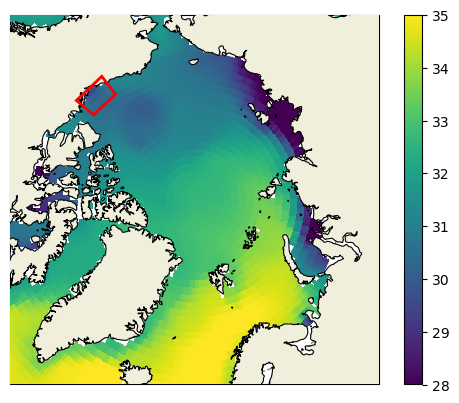

In [69]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs

# Plot the ECCO field
fig, ax, cbar, *_ = ecco.plot_proj_to_latlon_grid(
    lon_mg, 
    lat_mg, 
    mean_SSS,
    projection_type='stereo',
    show_colorbar=True,
    dx=1, dy=1,
    cmin=28, cmax=35,
    lat_lim=65,
    return_fig=True  # <== this ensures we get a usable fig/ax
)

cbar.set_label('Mean Surface Salinity [PSU]')

# Define the corners of the box in (lon, lat)
lon_min, lon_max = -143, -130
lat_min, lat_max = 69, 72
box_coords = [
    (lon_min, lat_min),
    (lon_max, lat_min),
    (lon_max, lat_max),
    (lon_min, lat_max),
    (lon_min, lat_min)  # close the loop
]

# Create and add the polygon to the map
polygon = mpatches.Polygon(
    box_coords,
    closed=True,
    edgecolor='red',
    facecolor='none',
    linewidth=2,
    transform=ccrs.PlateCarree(),  # must match the data's CRS
    zorder=200
)
ax.add_patch(polygon)

plt.show()


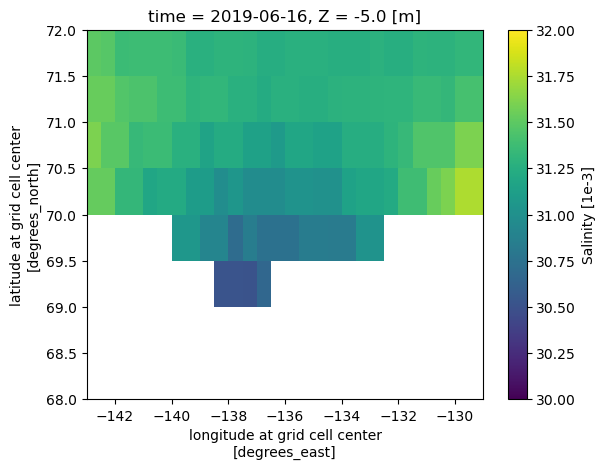

In [15]:
ds.SALT.sel(time='2019-06',longitude=slice(-143,-129),latitude=slice(68,72)).isel(Z=0).plot(vmin=30,vmax=32);

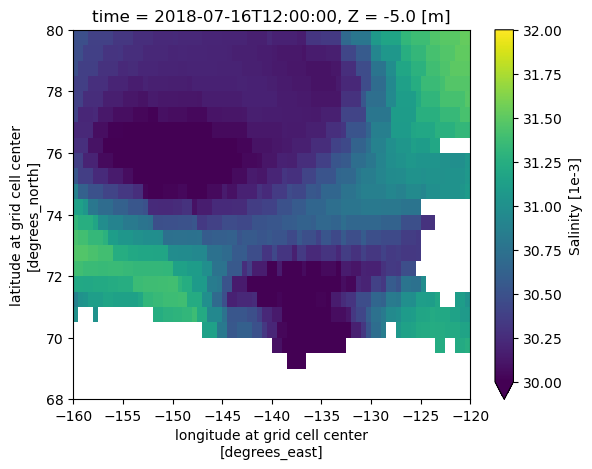

In [16]:
# ds.SALT.sel(time='2018-06',longitude=slice(-143,-129),latitude=slice(68,72)).isel(Z=0).plot(vmin=30,vmax=32);
ds.SALT.sel(time='2018-07',longitude=slice(-160,-120),latitude=slice(68,80)).isel(Z=0).plot(vmin=30,vmax=32);

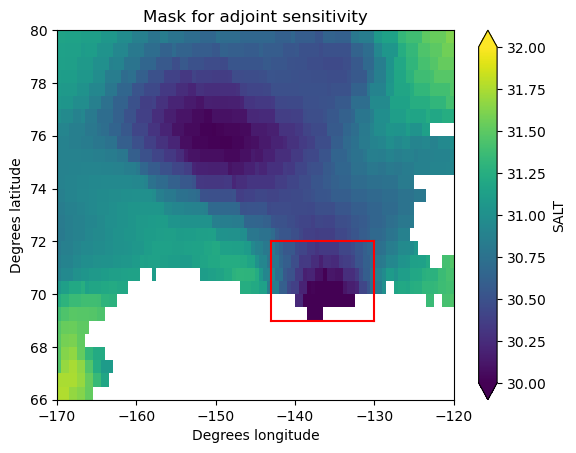

In [17]:
plt.plot((-143,-130), (69,69), color='red')
plt.plot((-143,-130), (72,72), color='red')
plt.plot((-143,-143), (69,72), color='red')
plt.plot((-130,-130), (69,72), color='red')
mean_SSS.plot(vmin=30,vmax=32);
plt.xlim(-170,-120)
plt.ylim(66,80);
plt.title('Mask for adjoint sensitivity')
plt.ylabel('Degrees latitude')
plt.xlabel('Degrees longitude');